In [1]:
%matplotlib inline

import time

import numpy as np
import tables as tb
import matplotlib.pyplot as plt

from detsim.io.hdf5_io import load_sensors
from detsim.position_signal import bin_minmax
from detsim.position_signal import get_no_sensors
from detsim.io.hdf5_io import get_sensor_binning
from detsim.io.hdf5_io import buffer_writer

from invisible_cities.reco                      import     tbl_functions as tbl
from invisible_cities.io.mcinfo_io import load_mcsensor_response
from invisible_cities.reco.peak_functions import indices_and_wf_above_threshold
from invisible_cities.reco.peak_functions import                 split_in_peaks
from invisible_cities.detsim.buffer_functions import calculate_binning
from invisible_cities.detsim.buffer_functions import trigger_finder
from invisible_cities.detsim.buffer_functions import calculate_buffers
from invisible_cities.core.system_of_units_c  import units

from functools import wraps

sens_wf = load_mcsensor_response('invisible_cities/database/test_data/Kr83_full_nexus_v5_03_01_ACTIVE_7bar_1evt.sim.h5')

In [2]:
dicts = [val for val in load_sensors(['invisible_cities/database/test_data/Kr83_full_nexus_v5_03_01_ACTIVE_7bar_1evt.sim.h5'], 'new', 6400)]
pmt_wid, sipm_wid = get_sensor_binning('invisible_cities/database/test_data/Kr83_full_nexus_v5_03_01_ACTIVE_7bar_1evt.sim.h5', 'new', 6400)

In [3]:
#pmt_binner  = calculate_binning(pmts [0].bin_width, 1e6)
#sipm_binner = calculate_binning(sipms[0].bin_width, 1e6)
binner = calculate_binning(1e6)

0.0 67500.0


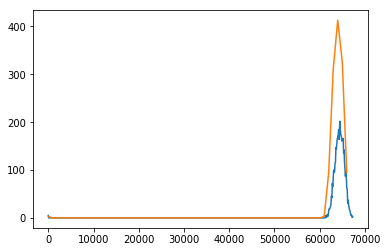

In [4]:
pmt_bins, pmt_q = binner(dicts[0]['pmt_wfs'])
min_bin, max_bin = bin_minmax(pmt_bins)
#sipm_bins, sipm_q = binner(sipms, pmt_bins[0], pmt_bins[-1] + pmts[0].bin_width)
plt.plot(pmt_bins[:-1], np.sum(pmt_q, axis=0))
print(min_bin, max_bin)
sipm_bins, sipm_q = binner(dicts[0]['sipm_wfs'], min_bin, max_bin)
plt.plot(sipm_bins[:-1], np.sum(sipm_q, axis=0))
#pmt_bins
#max_bin = np.ceil((pmt_bins[-1] + pmts[0].bin_width) / sipms[0].bin_width) * sipms[0].bin_width
#np.arange(pmt_bins[0]

In [5]:
trg_finder = trigger_finder(800, pmt_wid, 3)

In [6]:
trgs = trg_finder(np.sum(pmt_q, axis=0))

In [7]:
trgs

[0]

(12, 8000) (560, 800)


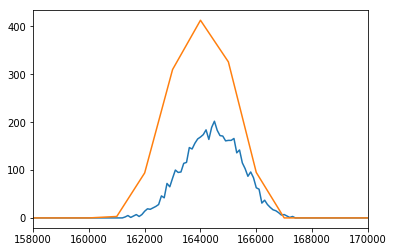

In [8]:
buffer_mus  = 800
pretrig_mus = 100
buffers = calculate_buffers(buffer_mus, pretrig_mus)
all_buffers = buffers(trgs, pmt_bins, pmt_q, sipm_bins, sipm_q)
plt.plot(np.arange(0, buffer_mus * units.mus, pmt_wid), np.sum(all_buffers[0][0], axis=0))
plt.plot(np.arange(0, buffer_mus * units.mus, sipm_wid), np.sum(all_buffers[0][1], axis=0))
plt.xlim(158000, 170000)
print(all_buffers[0][0].shape, all_buffers[0][1].shape)
#plt.ylim(-1, 10)

In [9]:
npmt, nsipm        = get_no_sensors('new', 6400)
nsamp_pmt          = int(buffer_mus * units.mus /  pmt_wid)
nsamp_sipm         = int(buffer_mus * units.mus / sipm_wid)
print(type(npmt), type(nsipm), type(nsamp_pmt), type(nsamp_sipm))

<class 'int'> <class 'int'> <class 'int'> <class 'int'>


In [10]:
with tb.open_file('muchTest.h5', 'w', filters = tbl.filters('ZLIB4')) as h5out:
    buffer_writer_ = buffer_writer(h5out, n_sens_eng = npmt, n_sens_trk = nsipm, length_eng = nsamp_pmt, length_trk = nsamp_sipm)
    
    buffer_writer_(dicts[0]['evt'], dicts[0]['pmt_ord'], dicts[0]['sipm_ord'], all_buffers)